<a href="https://colab.research.google.com/github/anushamahajan5/MOSAIC/blob/main/mosaic_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


In [ ]:
librosa.__version__

'0.10.0.post2'

In [ ]:
files_txt=glob("/content/drive/My Drive/explo_submission/ICBHI_final_database/*.txt")
files_audio=glob("/content/drive/My Drive/explo_submission/ICBHI_final_database/*.wav")
listi=[]
for i in files_txt:
  for j in files_audio:
    split_i=i.split(".")
    split_j=j.split(".")
    if (split_i[0]==split_j[0]):
      listi.append([i,j])


**DATA ANALYSIS**

In [ ]:
from IPython.display import Audio
sound_file = listi[4][1]
# Audio(sound_file, autoplay=True)

Text(0, 0.5, 'normalised data')

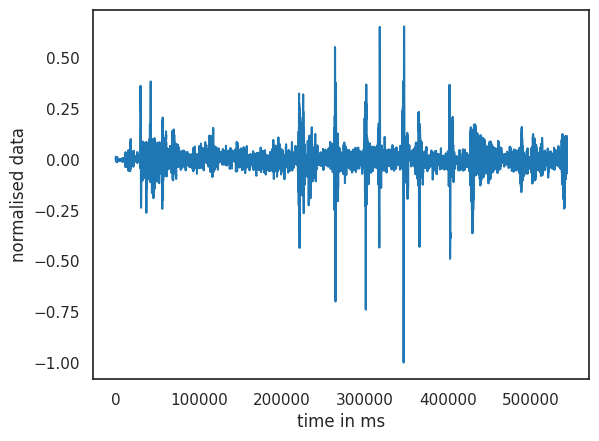

In [ ]:
audio, sr = librosa.load(sound_file)
plt.plot(audio)
plt.xlabel("time in ms")
plt.ylabel("normalised data")

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file)
    # plt.plot(audio)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [ ]:
len(listi)

810

In [ ]:
!pip install resampy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.4 MB/s eta 0:00:00


**DATA PREPROCESSING**

longest cycle:31770.0
shortest cycle:0.0
Fraction of samples less than 5000 miliseconds:0.969721767594108


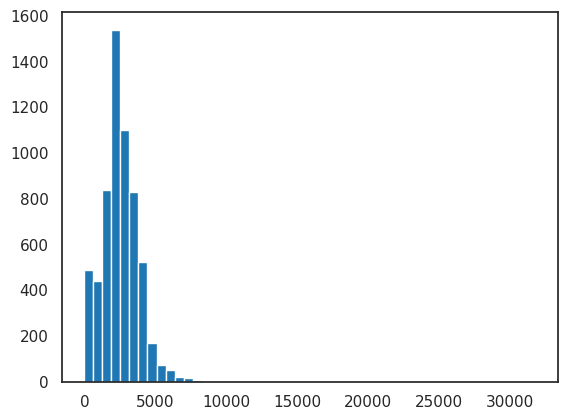

In [ ]:
from pydub import AudioSegment
from pathlib import Path
import os
from tqdm import tqdm

duration_list = []
final=[]
for i in listi:
  # print(type(i))
  features={0:[],1:[],2:[],3:[]}
  f=open(i[0],'r')
  for data in f:
    k=0
    for j in range(0,4):
      s=""
      while k<len(data) and data[k]!="\t" and data[k]!="\n":
        s+=data[k]
        k+=1
      features[j].append(float(s))
      k+=1

  audio_file=i[1]
  audio = AudioSegment.from_wav(audio_file)
  list_of_timestamps =features[0] #and so on in *seconds*
  start = 0
  for  idx,t in enumerate(list_of_timestamps):
      #break loop if at last element of list
      if idx == len(list_of_timestamps):
          break

      end = t * 1000 #pydub works in millisec
      # print "split at [ {}:{}] ms".format(start, end)
      audio_chunk=audio[start:end]
      # type(audio_chunk)
      y=features_extractor(audio_file)
      # y,sr= librosa.load(audio_file)
      final.append([ i[0].split(".")[0], y, features[0][idx], features[1][idx], features[2][idx], features[3][idx] ])
      duration= end-start
      duration_list.append(duration)
      start = end #pydub works in millisec
  # break
duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)


average cycle length:2515.9546317512277 ms
median cycle length:2452.0 ms
longest cycle:31770.0 ms
shortest cycle:0.0 ms
Fraction of samples less than 5000 miliseconds:0.969721767594108


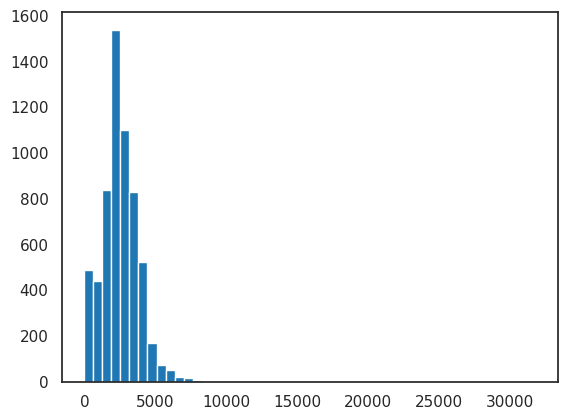

In [ ]:

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('average cycle length:{} ms'.format(np.mean(duration_list)))
print('median cycle length:{} ms'.format(np.median(duration_list)))
print('longest cycle:{} ms'.format(max(duration_list)))
print('shortest cycle:{} ms'.format(min(duration_list)))
threshold = 5000
print('Fraction of samples less than {} miliseconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))

In [ ]:
len(final)

In [ ]:
x=np.array(final[0][1])
y1=np.array(final[0][4])
y2=np.array(final[0][5])

for i in range(1,len(final)):
  x=np.append(x,final[i][1])
  y1=np.append(y1,final[i][4])
  y2=np.append(y2,final[i][5])

In [ ]:
x=x.reshape(6110,-1)
x.shape

In [ ]:
print(y1.shape)
print(y2.shape)

(6110,)
(6110,)


In [ ]:
print('Count of absence of both : {}' .format(np.count_nonzero(y1==0)))
print('Count of wheezes only : {}' .format(np.count_nonzero(y1==1)))
print('Count of crackles only : {}' .format(np.count_nonzero(y2==0)))
print('Count of presence of both : {}' .format(np.count_nonzero(y2==1)))

Count of absence of both : 3936
Count of wheezes only : 2174
Count of crackles only : 4880
Count of presence of both : 1230


In [ ]:
y=[]
for i in range(0,len(y1)):
  if y1[i]==0 and y2[i]==0: y= np.append(y,0)
  elif y1[i]==0 and y2[i]==1: y= np.append(y,1)
  elif y1[i]==1 and y2[i]==0 : y= np.append(y,2)
  else : y= np.append(y,3)
y.shape

TRAIN TEST SPLIT


In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [ ]:
X_train=X_train.reshape(X_train.shape[0],10,4,1)
X_test=X_test.reshape(X_test.shape[0],10,4,1)
X_train.shape

In [ ]:
X_train.shape

In [ ]:
y_train.shape

MODEL IMPLEMENTATION

In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.config.run_functions_eagerly(True)
# X_train.shape

2.12.0


In [ ]:
batch_size = 128
n_epochs = 15

In [ ]:
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
import tensorflow as tf
# K.clear_session()
sample_height=10
sample_width= 4

model = Sequential()
model.add(Conv2D(128,[10,4],  strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [10,4], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [10,4], padding = 'SAME'))
model.add(Conv2D(256, [5,2], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [2,2], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [2,2], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:

stats=model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, y_test), verbose=1)


In [ ]:
predictions = model.predict(X_test[0].reshape(-1,10,4,1))
predictions = np.argmax(predictions, axis = 1)
print(predictions)

In [ ]:

model.save('my_model.h5')

LOADING THE MODEL FILE WHICH IS DEVELOPED ABOVE

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/explo_submission/my_model.h5')


In [ ]:
# !unzip "/content/drive/My Drive/Test.zip" -d "/content/drive/My Drive/test_data"


In [ ]:
files_txt=glob("/content/drive/My Drive/explo_submission/test_data/Test/*.txt")
files_audio=glob("/content/drive/My Drive/explo_submission/test_data/Test/*.wav")
listi2=[]
for i in files_txt:
  for j in files_audio:
    split_i=i.split(".")
    split_j=j.split(".")
    if (split_i[0]==split_j[0]):
      listi2.append([i,j])
      # print(type(listi2[0]))
      # print(type(i))

In [ ]:
from IPython.display import Audio
sound_file = listi2[0][1]
# Audio(sound_file, autoplay=True)

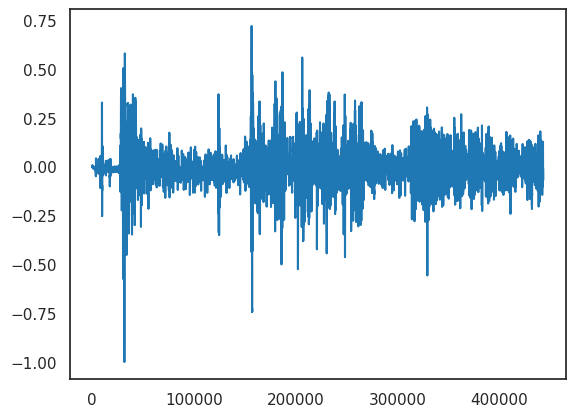

In [ ]:
audio, sr = librosa.load(sound_file)
plt.plot(audio)

In [ ]:
from decimal import Decimal

# num = "153.4564504586313134586"
# # calling Decimal()
# num = Decimal(num)

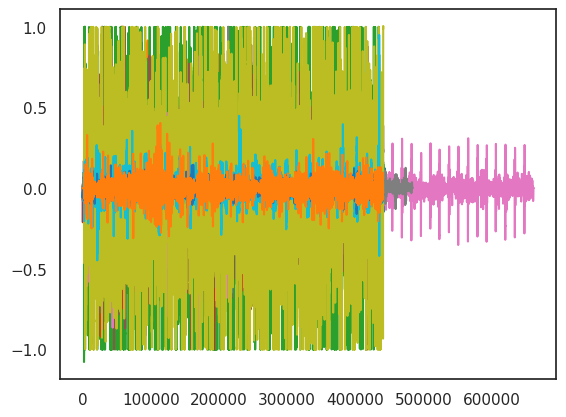

In [ ]:
from pydub import AudioSegment
from pathlib import Path
import os
from tqdm import tqdm

duration_list=[]
test_final=[]
for i in listi2:
  # print(type(i))
  features={0:[],1:[],2:[],3:[]}
  f=open(i[0],'r')
  for data in f:
    k=0
    for j in range(0,4):
      s=""
      while k<len(data) and data[k]!="\t" and data[k]!="\n":
        s+=data[k]
        k+=1
      # t=Decimal(s)
      if(s==""):
        s='0'
      features[j].append(float(s))
      k+=1

  audio_file=i[1]
  audio = AudioSegment.from_wav(audio_file)
  list_of_timestamps =features[0] #and so on in *seconds*
  start = 0
  for  idx,t in enumerate(list_of_timestamps):
      #break loop if at last element of list
      if idx == len(list_of_timestamps):
          break

      end = t * 1000 #pydub works in millisec
      duration= end-start
      duration_list.append(max(0,duration))
      # print "split at [ {}:{}] ms".format(start, end)
      audio_chunk=audio[start:end]
      # type(audio_chunk)
      y=features_extractor(audio_file)
      # y,sr= librosa.load(audio_file)
      test_final.append([ i[0].split(".")[0], y, features[0][idx], features[1][idx], features[2][idx], features[3][idx] ])
      start = end #pydub works in millisec
  audio, sample_rate = librosa.load(audio_file)
  plt.plot(audio)


average cycle length:2832.371111111111 ms
median cycle length:1906.3999999999996 ms
longest cycle:12928.0 ms
shortest cycle:0.0 ms
Fraction of samples less than 5000 miliseconds:0.8


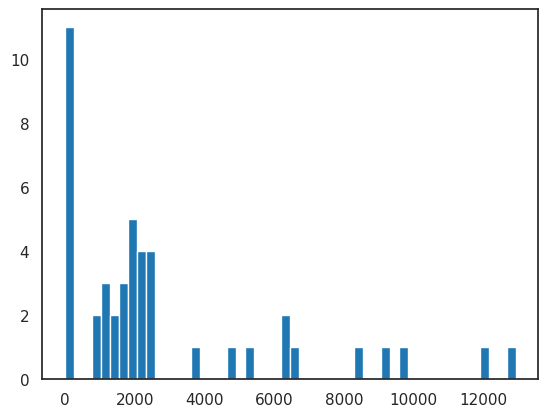

In [ ]:

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('average cycle length:{} ms'.format(np.mean(duration_list)))
print('median cycle length:{} ms'.format(np.median(duration_list)))
print('longest cycle:{} ms'.format(max(duration_list)))
print('shortest cycle:{} ms'.format(min(duration_list)))
threshold = 5000
print('Fraction of samples less than {} miliseconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))

In [ ]:
len(test_final)

In [ ]:
type(test_final)

In [ ]:
x_test=np.array(test_final[0][1])
y1_test=np.array(test_final[0][4])
y2_test=np.array(test_final[0][5])

for i in range(1,len(test_final)):
  x_test=np.append(x_test,test_final[i][1])
  y1_test=np.append(y1_test,test_final[i][4])
  y2_test=np.append(y2_test,test_final[i][5])


In [ ]:
len(x_test)

In [ ]:
len(test_final)

In [ ]:
x_test=x_test.reshape(-1,10,4,1)


In [ ]:
ans=[]
for i in x_test:
  predictions = new_model.predict(i.reshape(-1,10,4,1))
  predictions = np.argmax(predictions, axis = 1)
  ans.append(predictions)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


In [ ]:
# print(len(ans))
# print(ans)
type(ans[0])
print('Count of absence of both : {}' .format(np.count(y1_test==0)))
print('Count of wheezes only : {}' .format(np.count(y1_test==1)))
print('Count of crackles only : {}' .format(np.count(y2_test==0)))
print('Count of presence of both : {}' .format(np.count(y2_test==1)))

NameError: ignored

OUTPUT GENERATION

In [ ]:
out=[]
mp=['Both absent','Wheezes present','Crackles present','Both present']
for i in range(0,len(ans)):
  print(test_final[i][0]," ")
  print(ans[i])
  out.append([test_final[i][0].split("/")[-1:],test_final[i][2],test_final[i][3],mp[int(ans[i])] ])

with open("file.txt", 'w') as file:
        for row in out:
            s = " ".join(map(str, row))
            file.write(s+'\n')


/content/drive/My Drive/explo_submission/test_data/Test/118_1b1_Lr_sc_Litt3200  
[1]
/content/drive/My Drive/explo_submission/test_data/Test/118_1b1_Lr_sc_Litt3200  
[1]
/content/drive/My Drive/explo_submission/test_data/Test/118_1b1_Lr_sc_Litt3200  
[1]
/content/drive/My Drive/explo_submission/test_data/Test/118_1b1_Lr_sc_Litt3200  
[1]
/content/drive/My Drive/explo_submission/test_data/Test/124_1b1_Al_sc_Litt3200  
[0]
/content/drive/My Drive/explo_submission/test_data/Test/124_1b1_Al_sc_Litt3200  
[0]
/content/drive/My Drive/explo_submission/test_data/Test/124_1b1_Al_sc_Litt3200  
[0]
/content/drive/My Drive/explo_submission/test_data/Test/133_2p3_Al_mc_AKGC417L  
[2]
/content/drive/My Drive/explo_submission/test_data/Test/133_2p3_Al_mc_AKGC417L  
[2]
/content/drive/My Drive/explo_submission/test_data/Test/133_2p3_Al_mc_AKGC417L  
[2]
/content/drive/My Drive/explo_submission/test_data/Test/133_2p3_Al_mc_AKGC417L  
[2]
/content/drive/My Drive/explo_submission/test_data/Test/139_1b1_P